In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, util, transform
from PIL import Image

# 1. Entrene una red de Hopfield ‘82 con un conjunto de imágenes binarias.

Recordatorios de tamaños

El vector de la imagen original aplanada → (N,).

El vector de la imagen con ruido (x0) → (N,).

La matriz de pesos W → (N, N).

Todas las imagenes tienen que tener el mismo tamaño

### Pasos

1. Preprocesar los patrones. Las imagenes son binarias, están en 0 (negro) y 1/255 (blanco).

    Las redes de Holpfield trabajan con +1/-1

    Tengo que aplicar una función signo que se aplique a cada imagen. 

2. Aplanar los patrones
    La red Hopfield funciona con vectores de tamaño N (uno por neurona).

    Si la imagen es de 28x28, el vector tendrá 784 entradas.
    Convierto una matriz de 3D o 2D a un vector de 1D

### Definición de funciones a usar

In [ ]:
# Todas las imagenes tienen que tener el mismo tamaño
def preparar_patterns(img_paths: list, size=(45,60)) -> np.ndarray:
    img_aplanadas_vec = []
    for path in img_paths:
        img = Image.open(path).convert("1").resize(size)
        arr01 = np.array(img, dtype=np.uint8)
        signo = np.where(arr01 > 0, 1, -1).astype(np.int8)
        vec = signo.reshape(-1)
        img_aplanadas_vec.append(vec)
    patterns = np.stack(img_aplanadas_vec)
    return patterns

In [3]:
def calcular_matriz_conn(patterns):
    # La matriz se fuerza a ceros en la diagonal.
    P, N = patterns.shape # P es la cantidad de imagenes con la que quiero entrenar la red
    W = np.zeros((N, N), dtype=np.float32)
    for p in patterns:
        W += np.outer(p, p)
    W /= P
    np.fill_diagonal(W, 0)
    return W

In [4]:
def agg_ruido_img(img_1d: np.ndarray, frac: float, rng=None) -> np.ndarray:
    """Dado los patrones le agrego ruido dependiendo el porcentaje que se desee
    Parametros:
    img_1d: es el array de[1,-1] de 1D. Antes de convertirlo en un patrón para construir W.
    """
    rng = rng or np.random.default_rng()
    y = img_1d.copy()
    k = int(round(frac * img_1d.size))
    idx = rng.choice(img_1d.size, k, replace=False)
    y[idx] *= -1
    return y

In [5]:
def update_sync(s, W):
    h = W @ s
    out = np.sign(h).astype(np.int8)
    out[out == 0] = s[out == 0]
    return out

def update_async(s, W):
    y = s.copy()
    for i in np.random.permutation(y.size):
        h_i = W[i] @ y
        if   h_i > 0: y[i] =  1
        elif h_i < 0: y[i] = -1
    return y

def Hopfield_train(
    x0: np.ndarray,
    W: np.ndarray,
    mode: str = "async"
):
    """
    Parametros:
    x0: Estado inicial. Normalmente es la imagen con ruido.
    W: Matriz de pesos entrenada con los patrones
    """
    s = x0.copy()
    sweeps = 0 
    if mode == "async":
        while True:
            sweeps += 1
            s_new = update_async(s, W)
            if np.array_equal(s_new, s):
                return s_new, sweeps, True, False
            s = s_new
    elif mode == "sync":
        s_prev = None
        while True:
            sweeps += 1
            s_new = update_sync(s, W)
            if np.array_equal(s_new, s):           # punto fijo
                return s_new, sweeps, True, False
            if s_prev is not None and np.array_equal(s_new, s_prev):  # 2-ciclo
                return s_new, sweeps, True, True
            s_prev, s = s, s_new
    else:
        raise ValueError("mode debe ser 'async' o 'sync'")

In [6]:
#img_path = ['dataset/paloma.bmp', 'dataset/panda.bmp', 'dataset/perro.bmp', 'dataset/quijote.bmp', 'dataset/torero.bmp', 'dataset/v.bmp']
img_path = ['dataset/paloma.bmp']


In [7]:
patterns = preparar_patterns(img_path)
print(patterns.shape)   # (6, N)
print(np.unique(patterns))  # [-1  1]

(1, 2700)
[-1  1]


In [8]:
matriz_w = calcular_matriz_conn(patterns)

In [9]:
matriz_w

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]], shape=(2700, 2700), dtype=float32)

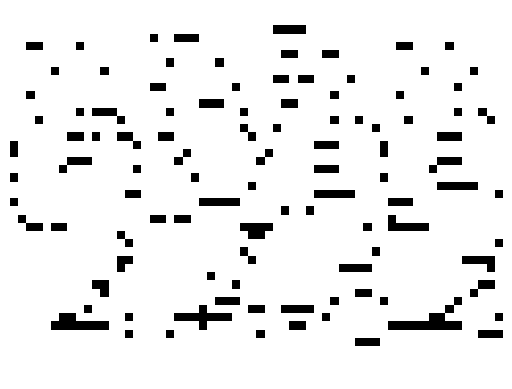

Patrón 0: convergió=True, sweeps=2


In [ ]:
def agg_ruido_img(img_1d: np.ndarray, frac: float, rng=None) -> np.ndarray:
    """Dado los patrones le agrego ruido dependiendo el porcentaje que se desee
    Parametros:
    img_1d: es el array de[1,-1] de 1D. Antes de convertirlo en un patrón para construir W.
    """
    rng = rng or np.random.default_rng()
    y = img_1d.copy()
    k = int(round(frac * img_1d.size))
    idx = rng.choice(img_1d.size, k, replace=False)
    y[idx] *= -1
    return y

In [19]:
path = 'dataset/paloma.bmp'
img = Image.open(path)
arr01 = np.array(img, dtype=np.uint8)

In [20]:
arr01.shape

(45, 60)

In [21]:
signo = np.where(arr01 > 0, 1, -1).astype(np.int8)
vec = signo.reshape(-1)
patterns = np.stack(vec)

In [22]:
patterns.shape

(2700,)

In [16]:
w = calcular_matriz_conn(patterns)

ValueError: not enough values to unpack (expected 2, got 1)